# Notebook for RDE stability analysis

See analysis_RDE.py for more information about the functions.

### 1. Initialization.

In [3]:
%load_ext autoreload
from analysis_RDE import *
import tkinter as tk
from tkinter import filedialog 
from tkinter import messagebox
import os
import pandas as pd
from numpy import savetxt

root = tk.Tk()
root.withdraw()
root.lift()
root.attributes("-topmost", True)

''

### 1.1 Introducting experimental parameters.

In [4]:
reference = 0               # V
A_geo = 0.196               # cm2
loading = 0.02              # mg/cm2
ir_comp = 26                # ohm
charge_ecsa = 0.000210      #C/cm2
Pt_mass = loading * A_geo   #mg
scan_rate = 0.05            #V/s for CO stripping

index = 10                  # number of lines of info to be removed

### 2. Choose which file(s) to analyze.

#### 2.A Analysis of one file: Open the file with the interesting voltage and current data.

In [23]:
%autoreload
nbr_files = 1
file = filedialog.askopenfilename(title="Choose the file to be analyzed.")
V, I = get_voltage_current(file, index)
print(file)

L:/P15 SEM/Linnéa/2024_02_01/ML14/ML14_M049_Cyc0002.txt


#### 2.B Analysis of several files: Open the files with the interesting voltage and current data.

In [5]:
nbr_files = 2  #not important, just not 1
files = filedialog.askopenfilenames(title="Choose the files to be analyzed.")
print(files)
data_matrix = []

for file in files: 
    V_i, I_i = get_voltage_current(file, index)
    data_matrix.append(V_i)
    data_matrix.append(I_i)

data_matrix = np.transpose(data_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M005_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M008_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M011_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M014_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M017_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M020_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M023_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M026_Cyc0001.txt')


### 3. Introduce background: choose the corresponding file(s).

In [6]:
%autoreload
if nbr_files == 1:
    background_file = filedialog.askopenfilename(title="Choose the background file.")
    print(background_file)
    background_V, background_I = get_background(background_file, index)
else:
    background_files = filedialog.askopenfilenames(title="Choose the background files.")
    print(background_files)
    background_matrix = []
    for i, background_file in enumerate(background_files): 
        V_i, I_i = get_background(background_file, index)
        background_matrix.append(V_i)
        background_matrix.append(I_i)

    background_matrix = np.transpose(background_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M005_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M008_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M011_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M014_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M017_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M020_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M023_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Stability/ML01_M026_Cyc0002.txt')


### 4. Corrections.
The following corrections can be made:
* Adjusting voltage to RHE potential.
* Background adjustment of current.
* iR-drop correction (usually done directly in Labview)

In [7]:
%autoreload
if nbr_files == 1:
    background_V_RHE = copy.deepcopy(background_V)
    background_I_RHE = copy.deepcopy(background_I)
    V_RHE = copy.deepcopy(V)
    I_corrected = copy.deepcopy(I)

    V_RHE = RHE_correction(V_RHE, reference)
    I_corrected = background_correction_current(I_corrected, background_I_RHE)   
else:
    background_RHE = copy.deepcopy(background_matrix)
    background_RHE = RHE_correction_background(background_RHE, reference)
    data_RHE = copy.deepcopy(data_matrix)
    corrected_data_RHE = copy.deepcopy(data_matrix)
    
    for i in range(len(data_matrix[0])):
        if i % 2 == 0:      #voltage are stored in even indexed columns
            data_RHE[:,i] = RHE_correction(data_RHE[:,i], reference)
            corrected_data_RHE[:,i] = RHE_correction(corrected_data_RHE[:,i], reference)
        else:               #current
            corrected_data_RHE[:,i] = background_correction_current(corrected_data_RHE[:,i], background_RHE[:,i])

### 5. Normalizing to geometric surface area and mass.

In [8]:
%autoreload
if nbr_files == 1:
    mass_I = copy.deepcopy(I_corrected)
    surface_I = copy.deepcopy(I_corrected)

    mass_I, surface_I = normalizing(mass_I, loading, A_geo)
else:
    mass_matrix = copy.deepcopy(corrected_data_RHE)
    surface_matrix = copy.deepcopy(corrected_data_RHE) 

    for i in range(1, len(data_matrix[0]), 2):   #only looping the current columns
        mass_matrix[:,i], surface_matrix[:,i] = normalizing(mass_matrix[:,i], loading, A_geo)
    

### 6. Plotting

Text(0.5, 1.0, 'CO stripping minus CV')

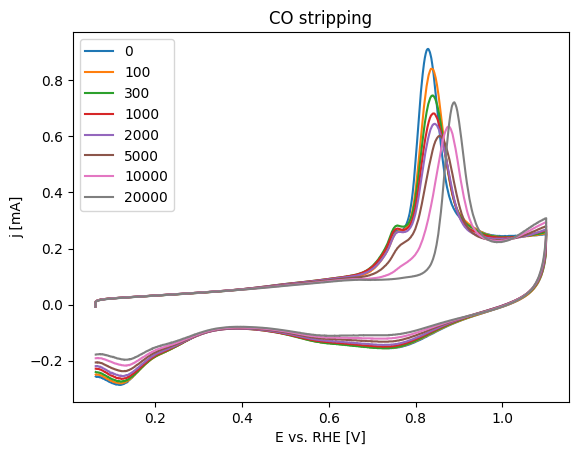

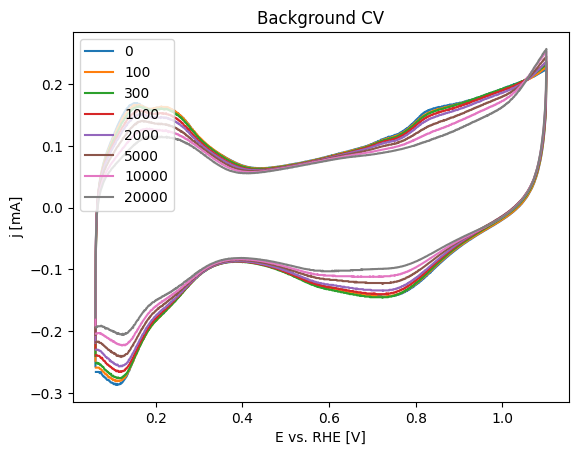

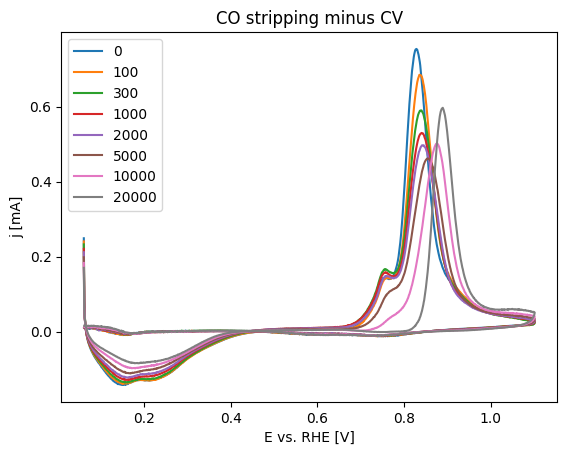

In [12]:
cycles = ['0', '100', '300', '1000', '2000', '5000','10000', '20000']

fig1, ax1 = plt.subplots()
for i in range(0,len(data_matrix[0]),2):
    ax1.plot(data_matrix[:,i],[1000*e for e in data_matrix[:,i+1]])
ax1.legend(cycles, loc='upper left')  
ax1.set_xlabel('E vs. RHE [V]')
ax1.set_ylabel('j [mA]')
ax1.set_title("CO stripping")

# Uncomment to get both background and CO in same plot
fig2, ax2 = plt.subplots()
for i in range(0,len(background_matrix[0]),2):
    #ax2.plot(data_matrix[:,i],[1000*e for e in data_matrix[:,i+1]])
    ax2.plot(background_matrix[:,i], [1000*e for e in background_matrix[:,i+1]])
ax2.legend(cycles, loc='upper left')
ax2.set_xlabel('E vs. RHE [V]')
ax2.set_ylabel('j [mA]')
#ax2.set_title('CO stripping and CV')
ax2.set_title("Background CV")

fig3, ax3 = plt.subplots()
for i in range(0,len(corrected_data_RHE[0]),2):
    ax3.plot(corrected_data_RHE[:,i], [1000*e for e in corrected_data_RHE[:,i+1]])
ax3.legend(cycles, loc='upper left')
ax3.set_xlabel('E vs. RHE [V]')
ax3.set_ylabel('j [mA]')
ax3.set_title("CO stripping minus CV")

### 7. Analysis.
Determining ECSA etc.

ECSA: 4.308929388827143 cm2
Specific ECSA: 109.92166808232508 m2/g(Pt)


Text(0.5, 1.0, 'CO stripping & background CV')

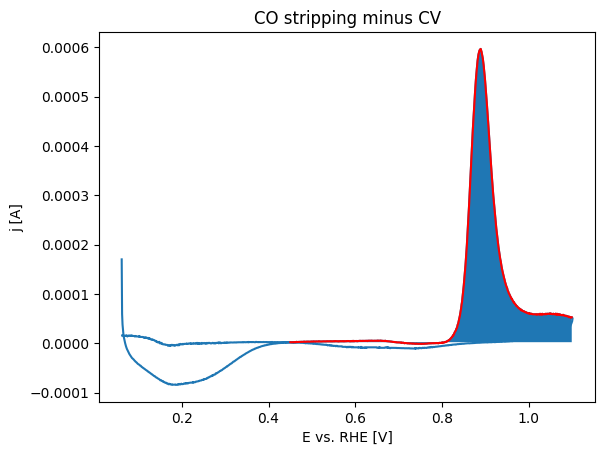

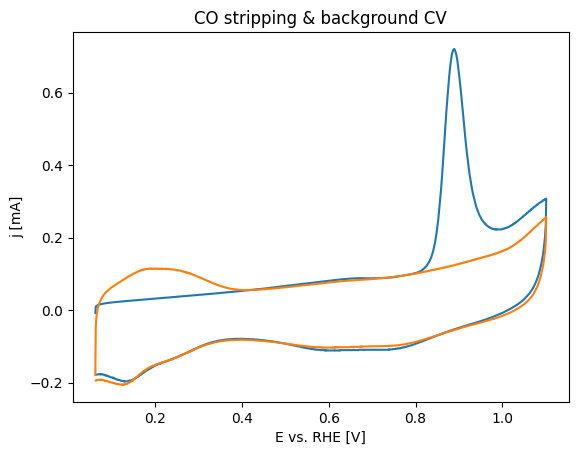

In [20]:
# Choose x-region to look at the ECSA (HUP, CO stripping peak)
lower_limit = 0.45
upper_limit = 1.1

V_index = 14
I_index = 15
voltage = list(copy.deepcopy(corrected_data_RHE[:,V_index])) #Choose which CV to look at. list to be able to use index() method
current = list(copy.deepcopy(corrected_data_RHE[:,I_index])) 
background_voltage = list(copy.deepcopy(background_matrix[:,V_index])) 
background_current = list(copy.deepcopy(background_matrix[:,I_index])) 

integration_start = next(x for x in voltage if x >= lower_limit)
integration_end = next(x for x in voltage if x >= upper_limit)

integration_interval = slice(voltage.index(integration_start), voltage.index(integration_end))
height = current[voltage.index(integration_start)]
charge = np.trapz(current[integration_interval], voltage[integration_interval]) - height * (upper_limit - lower_limit)
charge = charge / scan_rate   # V*A/(V*s)=A*s=C
ECSA = np.abs(charge/charge_ecsa)
specific_ECSA = ECSA/Pt_mass * 0.1  #converison to m2/g(Pt)
print('ECSA:', ECSA, 'cm2'
      '\nSpecific ECSA:', specific_ECSA, 'm2/g(Pt)')

fig1, ax1 = plt.subplots()
ax1.plot(voltage, current)
ax1.plot(voltage[integration_interval], current[integration_interval], 'red')
ax1.fill_between(voltage[integration_interval], current[integration_interval], height)
ax1.set_xlabel('E vs. RHE [V]')
ax1.set_ylabel('j [A]')
ax1.set_title('CO stripping minus CV')

fig2, ax2 = plt.subplots()
ax2.plot(data_RHE[:,V_index], [i*1000 for i in data_RHE[:,I_index]])
ax2.plot(background_voltage, [i*1000 for i in background_current])
ax2.set_xlabel('E vs. RHE [V]')
ax2.set_ylabel('j [mA]')
ax2.set_title('CO stripping & background CV')

Text(0.5, 1.0, 'ECSA decrease with number of cycles')

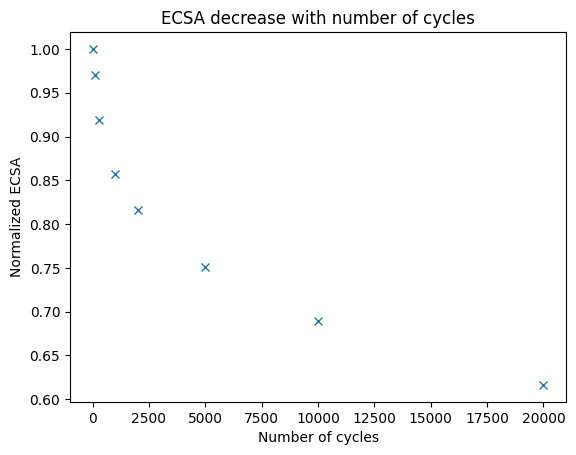

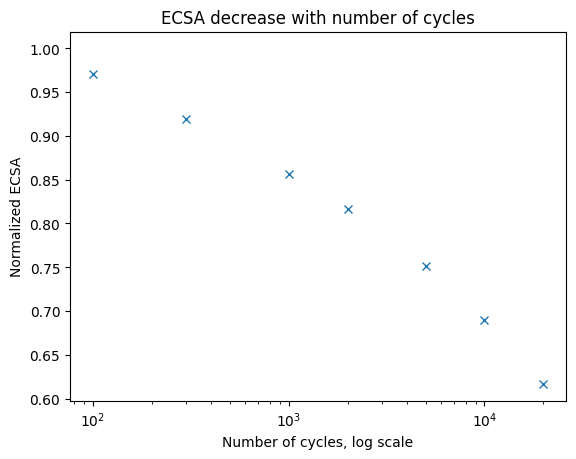

In [19]:
# Fill in the above calculated ECSAs
areas = [6.990927662542855, 6.783552519253333, 6.425373009115713, 5.98958658555476, 5.708345546805715, 5.25000320395238, 4.821517610802381, 4.308929388827143]

cycles_int = list(map(int, cycles))
normalized_area = [i/areas[0] for i in areas]

fig1, ax1 = plt.subplots()
ax1.plot(cycles_int, normalized_area, 'x')
ax1.set_xlabel("Number of cycles")
ax1.set_ylabel("Normalized ECSA")
ax1.set_title("ECSA decrease with number of cycles")

fig2, ax2 = plt.subplots()
ax2.plot(cycles_int, normalized_area, 'x')
ax2.semilogx()
ax2.set_xlabel("Number of cycles, log scale")
ax2.set_ylabel("Normalized ECSA")
ax2.set_title("ECSA decrease with number of cycles")